In [72]:
from os import listdir
from os.path import join, isfile
from deap import base, creator, tools, algorithms

import random
import numpy as np
import matplotlib.pyplot as plt

plt_styles = plt.style.available
plt.style.use(plt_styles[7])


In [73]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]
    

In [74]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [75]:
n_problem = int(input(f"Elige el problema (1-{len(inPaths)}): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of cars.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [76]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:-1]

# Car accessibility.
adapted = prob[-1]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [77]:
toolbox = base.Toolbox()

In [78]:
if not hasattr(creator, "FitnessMax"):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))

if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMax)


In [79]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [80]:
def sort_rides(car_rides):
    def sort_ride(ride):
        a, b, x, y, s, f, _ = ride
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance

    return sorted(car_rides, key=lambda ride: sort_ride(ride[1]))


def get_rides_from_ind(individual):
    cars_rides = np.full(F, None)

    for i, car in enumerate(individual):
        v_r = cars_rides[car]

        if v_r is None:
            v_r = []

        ride = rides[i]
        v_r.append([i, ride])

        cars_rides[car] = v_r

    return cars_rides


def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


In [81]:


def calc_fitness(car_rides):
    fitness = 0
    step = 0
    pos = [0, 0]

    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, earliest_start, latest_finish, _ = ride
        origin = [a, b]
        destiny = [x, y]

        # 1.- Go to origin.
        step += dis(pos, origin)

        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
            fitness += B
            step = earliest_start

        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des

        # 4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
            fitness += dis_ori_des

        # 5.- Update position.
        pos = destiny

        # 6.- Check if reached max distance with one car.
        if step > T:
            break

    return fitness


def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0

    for _, car_rides in enumerate(all_rides):
        if car_rides is not None:
            _fitness = calc_fitness(car_rides)
            fitness += _fitness

    return fitness,


In [82]:
TOURNSIZE = 3
INDPB = 0.2

toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, indpb=INDPB, low=0, up=F-1)
toolbox.register("evaluate", eval_ind)


In [83]:
NIND = 300

pop = toolbox.population(n=NIND)


In [84]:
ind = toolbox.individual()

print("Individuo")
print(ind[1:20])

print("Individuo ANTES de evaluar")
print(f"Valid: {ind.fitness.valid}")

ind.fitness.values = eval_ind(ind)

print("Individuo TRAS evaluar")
print(f"Valid: {ind.fitness.valid}. Fitness = {ind.fitness.values}")


Individuo
[65, 24, 15, 31, 31, 77, 62, 9, 8, 40, 48, 67, 19, 40, 73, 80, 4, 52, 30]
Individuo ANTES de evaluar
Valid: False
Individuo TRAS evaluar
Valid: True. Fitness = (9460489.0,)


In [85]:
def get_penalty(ind):
    pen = 0

    for i_ride, i_car in enumerate(ind):
        adapted_ride = rides[i_ride][-1]
        adapted_car = adapted[i_car]

        if adapted_car == 0 and adapted_ride == 1:
            pen += 1

    return pen


def distance(ind):   
    def constant(pen): return pen
    def lineal(pen): return pen*2
    def quadratic(pen): return pen**2

    pen = get_penalty(ind)
    dis = lineal(pen)
    return dis


def feasible(ind):
    pen = get_penalty(ind)
    threshold = B  # Bonus value of problem.
    return pen <= threshold


![Constraints](https://deap.readthedocs.io/en/master/_images/constraints.png)

In [86]:
DISTANCE_OFFSET = 0

toolbox.decorate("evaluate", tools.DeltaPenality(
    feasible, DISTANCE_OFFSET, distance))


In [87]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)
stats.register("avg", np.average)


In [88]:
NGEN = 80
CXPB = 0.8
MUTPB = 0.2

pop, logbook = algorithms.eaSimple(
    pop, toolbox, CXPB, MUTPB, NGEN, stats, verbose=False)

In [89]:
best_sol = tools.selBest(pop, k=1)[0]
pen_best_sol = get_penalty(best_sol)

print(f"El resultado de la evolución es:")
print(logbook)
print(
    f"Mejor solución es {best_sol[1:10]} con fitness {eval_ind(best_sol)} y pen {pen_best_sol}")


El resultado de la evolución es:
gen	nevals	min  	max  	std    	avg     
0  	300   	-5512	-5294	42.1117	-5402.95
1  	257   	-5476	-5284	32.6822	-5368.37
2  	269   	-5444	-5266	31.7653	-5344.79
3  	259   	-5434	-5232	31.8167	-5322.93
4  	246   	-5408	-5224	30.8005	-5300.3 
5  	254   	-5382	-5198	29.7721	-5281.1 
6  	228   	-5344	-5180	28.828 	-5259.77
7  	248   	-5356	-5134	32.4224	-5239.94
8  	267   	-5338	-5132	32.0669	-5220.85
9  	244   	-5312	-5120	30.9673	-5203.4 
10 	248   	-5310	-5108	31.9728	-5187.76
11 	250   	-5334	-5068	33.4324	-5170.78
12 	247   	-5282	-5068	36.2488	-5152.7 
13 	258   	-5244	-5044	34.9435	-5133.41
14 	259   	-5254	-5028	38.7415	-5118.8 
15 	253   	-5204	-5016	40.0826	-5098.62
16 	238   	-5214	-4988	40.6705	-5077.08
17 	260   	-5184	-4986	38.027 	-5060.87
18 	240   	-5162	-4976	34.2709	-5043.51
19 	257   	-5158	-4962	39.8143	-5035.37
20 	236   	-5150	-4960	39.19  	-5022.17
21 	259   	-5144	-4946	39.6921	-5011.2 
22 	251   	-5132	-4942	36.9479	-4997.84
23 	230

Max value: 4750.0


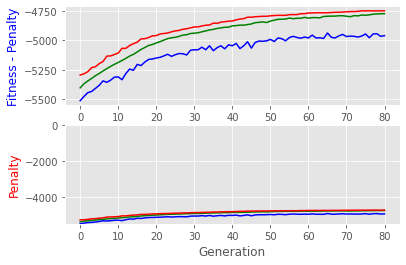

In [90]:
def plot_pen_fitness(lb):
    gen = lb.select("gen")
    avgs = lb.select("avg")
    maxs = lb.select("max")
    mins = lb.select("min")

    print(f"Max value: {abs(max(maxs))}")
    min_value = min(mins)

    _, (ax1, ax2) = plt.subplots(2)

    ax1.plot(gen, avgs, "g-", label="Average Fitness")
    ax1.plot(gen, maxs, "r-", label="Maxs Fitness")
    ax1.plot(gen, mins, "b-", label="Mins Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness - Penalty", color="b")

    ax2.plot(gen, avgs, "g-", label="Average Fitness")
    ax2.plot(gen, maxs, "r-", label="Maxs Fitness")
    ax2.plot(gen, mins, "b-", label="Mins Fitness")
    ax2.set_xlabel("Generation")
    ax2.set_ylim([min_value, 0])
    ax2.set_ylabel("Penalty", color="r")

    plt.show()


plot_pen_fitness(logbook)


In [91]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

cars_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in cars_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")